# MWDB Phase 1

## Task 0: exploring the data
In this section, we import the dataset and study its meta-data.

In [252]:
# Import the dataset
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import pandas as pd
import os
img_data = fetch_olivetti_faces(data_home=None, shuffle=False, random_state=0, download_if_missing=True)
img_data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

##### Printing the meta-data
From this we can see that:
1. The data has 40 classes (Images of 40 people)
2. 400 samples (40 people x 10 images each)
3. 4096 dimensionaloty (64 x 64 image matrices)
4. Features scaled between 0 and 1 (0 corresponds to 0 and 1 to 255 in greyscale)

From the keys of this dataset, it is clear that data consists of:
1. data - Array of lattened 64 x 64 images in a 1D array \[Dimensions: 40 x 4096\]
2. images - Array of 64 x 64 images in a 2D array \[Dimensions: 40 x 64 x 64\]
3. target - Array of person IDs
4. DESCR - Description of dataset

In [253]:
print(img_data["DESCR"])
img_data.keys()

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

dict_keys(['data', 'images', 'target', 'DESCR'])

## Task 1: Implementation of models onto the given image

In [254]:
images = img_data["images"]
input_img=images[0]

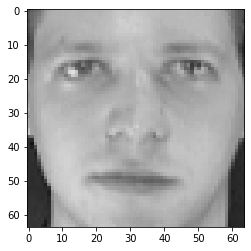

In [255]:
import matplotlib.pyplot as plt
# images lies in between 0 and 1 so setting vmin and vmax as 0 and 1
plt.imshow(images[0], cmap='gray', vmin=0, vmax=1)
plt.show()

#### Color moments

In [256]:
# Mean of an image defines the average colour among that local area
def get_mean_img(input_img, output_dim):
  out=np.empty(output_dim)
  for i in range(output_dim[0]):
    for j in range(output_dim[1]):
      out[i][j]=(input_img[i*(input_img.shape[0]//output_dim[0]):(i+1)*(input_img.shape[0]//output_dim[0]), j*(input_img.shape[1]//output_dim[1]):(j+1)*(input_img.shape[1]//output_dim[1])].mean())
  return out.reshape(output_dim)

# Standard deviation of an image defines the variation of the light intensity amongst that local region
def get_std_dev_img(input_img, output_dim):
  out=np.empty(output_dim)
  for i in range(output_dim[0]):
    for j in range(output_dim[1]):
      out[i][j]=(input_img[i*(input_img.shape[0]//output_dim[0]):(i+1)*(input_img.shape[0]//output_dim[0]), j*(input_img.shape[1]//output_dim[1]):(j+1)*(input_img.shape[1]//output_dim[1])].std())
  return out.reshape(output_dim)

# Calculating skewness based on Pearson Mode Skewness
#  If the skewness is negative, the histogram is negatively skewed. 
# That means its left tail is longer or fatter than its right one. 
# Therefore, the frequency over the darker intensities (closer to zero) is wider spread (less concentrated, but not necessarily less frequent than the right tail!). The positive skewness is the opposite.
# https://stats.stackexchange.com/questions/211377/skewness-and-kurtosis-in-an-image
# Cite Peraon formula and numpy libraries
def get_skew_img(input_img, output_dim, mean_img=np.array([]), std_img=np.array([])):
    if mean_img.shape==np.array([]).shape:
    mean_img=get_mean_img(input_img, output_dim)
    if std_img.shape==np.array([]).shape:
    std_img=get_std_dev_img(input_img, output_dim)

    median_img=np.empty(output_dim)
    for i in range(output_dim[0]):
    for j in range(output_dim[1]):
        median_img[i][j]=np.median(input_img[i*(input_img.shape[0]//output_dim[0]):(i+1)*(input_img.shape[0]//output_dim[0]), j*(input_img.shape[1]//output_dim[1]):(j+1)*(input_img.shape[1]//output_dim[1])])
    return 3*(mean_img-median_img)/std_img
  
def get_cm8x8(input_img, output_dim):
    cm8x8=[]
    cm8x8.append(get_mean_img(input_img, output_dim))
    cm8x8.append(get_std_dev_img(input_img, output_dim))
    cm8x8.append(get_skew_img(input_img, output_dim, mean_img=cm8x8[0], std_img=cm8x8[1]))
    cm8x8=np.array(cm8x8)
    return cm8x8

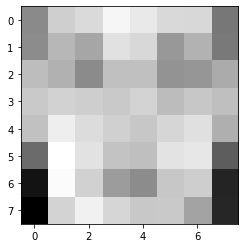

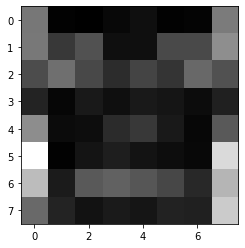

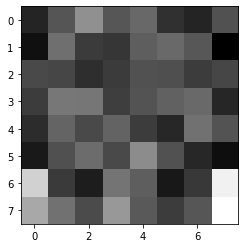

In [257]:
# Defining array for color moments
output_dim=(8,8)

cm8x8 = get_cm8x8(input_img, output_dim)
# Picture of mean of image
plt.imshow(cm8x8[0], cmap='gray', vmin=cm8x8[0].min(), vmax=cm8x8[0].max())
plt.show()

# For overall picture of std deviation
# plt.imshow(cm8x8[1], cmap='gray', vmin=0, vmax=1)
# For more sensitive zoomed in picture of std deviation
plt.imshow(cm8x8[1], cmap='gray', vmin=cm8x8[1].min(), vmax=cm8x8[1].max())
plt.show()


# For overall picture of skewness
# plt.imshow(cm8x8[2], cmap='gray', vmin=-1, vmax=1)
# For more sensitive zoomed in picture of skewness
plt.imshow(cm8x8[2], cmap='gray', vmin=cm8x8[2].min(), vmax=cm8x8[2].max())
plt.show()

#### Extended local binary pattern
http://researchspace.csir.co.za/dspace/bitstream/handle/10204/6491/Mdakane_2012.pdf?isAllowed=y&sequence=1

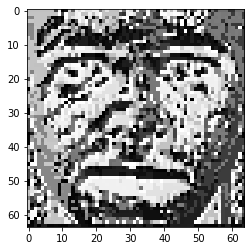

In [258]:
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
# ELBP can be used for border detection
from skimage.feature import local_binary_pattern
def get_elbp(input_img, neighbours=8, radius=1):
    return local_binary_pattern(input_img, neighbours, radius, method='uniform')

elbp = get_elbp(input_img, neighbours=8, radius=1)
plt.imshow(elbp, cmap='gray', vmin=elbp.min(), vmax=elbp.max())
plt.show()

#### Histograms of oriented gradients, HOG

In [259]:
hog_dict={
    "orientation_bins": 9,
    "cell_size": 8,
    "block_size": 2,
    "orientated_gradients": False, # ? ASK explaination of this parameter
    "l2_thres": 0.2,
    "norm_type": 'L2-Hys'       # normalization corressponding to max 0.2 threshold
}

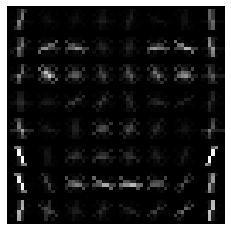

In [260]:
from skimage.feature import hog
# From each region, 9 numbers are extracted for angles:: TODO
def get_hog(input_img, hog_dict):
    fd, hog_image = hog(input_img, 
                      orientations=hog_dict["orientation_bins"], 
                      pixels_per_cell=(hog_dict["cell_size"], hog_dict["cell_size"]), 
                      cells_per_block=(hog_dict["block_size"], hog_dict["block_size"]), 
                      block_norm = hog_dict["norm_type"],
                      visualize=True, 
                      # feature_vector=False,
                      multichannel=False # image is grayscale, deprecated by channel_axis, can be replaced if version>0.19
                      # channel_axis =None # image is grayscale
                      )
    return np.array(fd), hog_image
plt.axis("off")
fd, hog_image = get_hog(input_img, hog_dict)
plt.imshow(hog_image, cmap="gray")

In [261]:
# how fs is defined
import math
math.sqrt(fd.shape[0]/9)

14.0

## Task 2 : Implementation of extraction and storage of feature descriptors for all images in a folder.

In [262]:
# Load file directory into google colab 
from google.colab import drive
drive.mount('/content/drive')
base0_dir = "/content/drive/MyDrive/MWDB/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [263]:
# Save all arrays from dataset as greyscale images
# Using PIL as matplotlib takes > 5min to save and PIL < 30 seconds
# Note: PIL is smart so if u ran and deleted these images before, make sure to empty your trash before running the same code again
from PIL import Image
import os

def save_all_images(input_dir, img_data):   
    if not os.path.isdir(input_dir):
    os.makedirs(input_dir)

    # Save all input images
    for i in range(img_data["images"].shape[0]):
        # if not os.path.isdir(input_dir + f"{img_data['target'][i]}/"):
        #   os.makedirs(input_dir + f"{img_data['target'][i]}/")

        result = Image.fromarray((img_data["images"][i]* 255).astype(np.uint8))
        # result.save(input_dir + f"{img_data['target'][i]}/{i%10}.png") 
        result.save(input_dir + f"{i}.png") 

In [264]:
# Defining parameters for feature extraction
output_dim=(8,8)
hog_dict={
    "orientation_bins": 9,
    "cell_size": 8,
    "block_size": 2,
    "orientated_gradients": False, # ? ASK explaination of this parameter
    "l2_thres": 0.2,
    "norm_type": 'L2-Hys'       # normalization corressponding to max 0.2 threshold
}

import pandas as pd
from numpy import savetxt
from numpy import loadtxt
def get_feature_vectors(image, name, output_dim, sub_features_dir, hog_dict, feature_visualization=False):
    cm8x8 = get_cm8x8(image, output_dim)
    if feature_visualization:
        out = Image.fromarray((cm8x8[0]).astype(np.uint8))
        out.save(os.path.join(features_dir, sub_features_dir[0], f"{name}.png")) 
        out = Image.fromarray((cm8x8[1]).astype(np.uint8))
        out.save(os.path.join(features_dir, sub_features_dir[1], f"{name}.png")) 
        out = Image.fromarray((cm8x8[2]).astype(np.uint8))
        out.save(os.path.join(features_dir, sub_features_dir[2], f"{name}.png"))

    elbp_out = get_elbp(image, neighbours=8, radius=1)
    if feature_visualization:
        out = Image.fromarray((elbp_out).astype(np.uint8))
        out.save(os.path.join(features_dir, sub_features_dir[3], f"{name}.png")) 

    hog_out, img = get_hog(image, hog_dict)
    if feature_visualization:
        out = Image.fromarray((img).astype(np.uint8))
        out.save(os.path.join(features_dir, sub_features_dir[4], f"{name}.png")) 
  
    return cm8x8, elbp_out, hog_out

# Save all features as images(for visualization) and features (color moments, hog and elbp)
def save_all_img_features(images, output_dim, features_dir, sub_features_dir, hog_dict, feature_visualization = False, img_ids=None):
    if img_ids!=None:
        pd.DataFrame(enumerate(img_ids),columns=["image_id", "image_idx"]).to_csv(os.path.join(features_dir, "image_ids.csv"),index=False)
    else:
        pd.DataFrame(enumerate(range(images.shape[0])),columns=["image_id", "image_idx"]).to_csv(os.path.join(features_dir, "image_ids.csv"),index=False)

    img_lst = []
    cm8x8_lst = [] 
    elbp_lst = [] 
    hog_lst = [] 

    for i in range(images.shape[0]):  
        img_lst.append(images[i].flatten())
        cm8x8, elbp_out, hog_out = get_feature_vectors(images[i], i, output_dim, sub_features_dir, hog_dict, feature_visualization=False)
        cm8x8 = (cm8x8-np.min(cm8x8))/ (np.max(cm8x8)-np.min(cm8x8))
        elbp_out = (elbp_out-np.min(elbp_out))/ (np.max(elbp_out)-np.min(elbp_out))
        hog_out = (hog_out-np.min(hog_out))/ (np.max(hog_out)-np.min(hog_out))

        cm8x8_lst.append(cm8x8.flatten())
        elbp_lst.append(elbp_out.flatten())
        hog_lst.append(hog_out)
    pd.DataFrame(img_lst).to_csv(os.path.join(features_dir, "images.csv"),index=False)
    pd.DataFrame(cm8x8_lst).to_csv(os.path.join(features_dir, "cm8x8.csv"),index=False)
    # elbp_lst = (elbp_lst-np.min(elbp_lst))/ (np.max(elbp_lst)-np.min(elbp_lst))
    pd.DataFrame(elbp_lst).to_csv(os.path.join(features_dir, "elbp.csv"),index=False)
    # hog_lst = (hog_lst-np.min(hog_lst))/ (np.max(hog_lst)-np.min(hog_lst))
    pd.DataFrame(hog_lst).to_csv(os.path.join(features_dir, "hog.csv"),index=False)


In [265]:
# read all saved images
import glob
input_dir = input("Enter path of images directory:")

base_dir = base0_dir if input_dir=="" else input_dir.rstrip("/").rsplit("/",1)[0]
features_dir=os.path.join(base_dir, input_dir.rstrip("/").rsplit("/",1)[1] + "_image_features/") if input_dir!="" else os.path.join(base_dir, "image_features/")
sub_features_dir = ["mean","std","skew","elbp","hog"]
# Create folders for images if they do not exist
if not os.path.isdir(features_dir):
    os.makedirs(features_dir)
for dir in sub_features_dir:
    if not os.path.isdir(os.path.join(features_dir, dir)):
        os.makedirs(os.path.join(features_dir, dir))

image_dir=base_dir + "input_images/"
# save_all_images(input_dir, img_data)

features_dir=os.path.join(base_dir, input_dir.rstrip("/").rsplit("/",1)[1] + "_image_features/") if input_dir!="" else os.path.join(base_dir, "image_features/")
input_dir = image_dir if input_dir=="" else input_dir

images = []
img_all_names = []
for f in glob.iglob(input_dir + "*"):
    img_all_names.append(f)
    images.append(np.asarray(Image.open(f)))

images = np.array(images)
save_all_img_features(images, output_dim, features_dir, sub_features_dir, hog_dict, feature_visualization = False, img_ids=img_all_names)

Enter path of images directory:/content/drive/MyDrive/MWDB/set1/


## Task 3 : Implementation of top-k similarity search

In [295]:
from faiss.swigfaiss import index_factory
from scipy.spatial import distance
# Top K image search using original images
# !pip uninstall faiss
!pip install faiss-cpu --no-cache
# Here I am using a library named faiss for the similarity search
# Eucleadean and cosine:: TODO :: why this and not other distances
import faiss                   # make faiss available
import random
from scipy.stats import wasserstein_distance

def euclidean(xb, k, xq):
    dimension = xb.shape[1]    # dimensions of each vector                         

    index = faiss.IndexFlatL2(dimension)   # build the index, d=size of vectors 
    # here we assume xb contains a n-by-d numpy matrix of type float32
    index.add(xb)                  # add vectors to the index
    # print(f"Total comparisions: {index.ntotal}")
    return index.search(xq, k)

def cosine(xb, k, xq):
    em = np.array([distance.cosine(i,xq) for i in xb])
    idx = np.argpartition(em, k)[:k]
    return em[idx], idx

def manhattan(xb, k, xq):
    man = np.sum(np.absolute(xb-xq), axis=1)
    idx = np.argpartition(man, k)[:k]
    return man[idx], idx

def earth_movers(xb, k, xq):
  # em = np.array([wasserstein_distance(i,xq[0]) for i in xb])
    em = np.array([wasserstein_distance(np.histogram(i)[1],np.histogram(xq)[1]) for i in xb])
    idx = np.argpartition(em, k)[:k]
    return em[idx], idx

def top_k_match(xb, k, xq, method="euclidean"):
    if method=="euclidean":
        return euclidean(xb, k, xq)
    elif method=="cosine":
        return cosine(xb, k, xq)
    elif method=="manhattan":
        return manhattan(xb, k, xq)
    elif method=="earth_movers":
        return earth_movers(xb, k, xq)

def get_image_file(features_dir, image_ids):
    df = pd.read_csv(os.path.join(features_dir, "image_ids.csv"))#.iloc[image_ids]
    return df["image_idx"].to_list()
  
# FROM STEP 2
input_dir = input("Enter path of images directory:")
input_k = input("Enter value of k:")
input_img = input("Enter input image path:")
selected_feature = input("Enter feature to compare:")

image_dir=base_dir + "input_images/"
base_dir = base0_dir if input_dir=="" else input_dir.rstrip("/").rsplit("/",1)[0]
input_dir = image_dir if input_dir=="" else input_dir
feature = "all" if selected_feature=="" else selected_feature

features_dir=os.path.join(base_dir, input_dir.rstrip("/").rsplit("/",1)[1] + "_image_features/") if input_dir=="" else os.path.join(base_dir, "image_features/")
sub_features_dir = ["mean","std","skew","elbp","hog"]
# Create folders for images if they do not exist
if not os.path.isdir(features_dir):
  os.makedirs(features_dir)
for dir in sub_features_dir:
      if not os.path.isdir(os.path.join(features_dir, dir)):
        os.makedirs(os.path.join(features_dir, dir))

images = []
img_all_names = []
for f in glob.iglob(input_dir + "*"):
    img_all_names.append(f)
    images.append(np.asarray(Image.open(f)))

k = 10 if input_k=="" else min(len(images), int(input_k))
images = np.array(images)
save_all_img_features(images, output_dim, features_dir, sub_features_dir, hog_dict, feature_visualization = False, img_ids=img_all_names)

in_image = np.asarray(Image.open(f))
in_image_cm, in_image_elbp,in_image_hog= get_feature_vectors(in_image, input_img, output_dim, sub_features_dir, hog_dict)
in_image_cm=in_image_cm.flatten()
in_image_cm = (in_image_cm-np.min(in_image_cm))/ (np.max(in_image_cm)-np.min(in_image_cm))
in_image_elbp=in_image_elbp.flatten()
in_image_elbp = (in_image_elbp-np.min(in_image_elbp))/ (np.max(in_image_elbp)-np.min(in_image_elbp))
in_image_hog=in_image_hog.flatten()
in_image_hog = (in_image_hog-np.min(in_image_hog))/ (np.max(in_image_hog)-np.min(in_image_hog))

# STEP 3 continued
# read all image features and store in a dictionary
feature_dict = {
    "img": np.array(pd.read_csv(os.path.join(features_dir, "images.csv")), order='C').astype(np.float32),
    "mean": np.array(pd.read_csv(os.path.join(features_dir, "cm8x8.csv")).iloc[: , :64], order='C').astype(np.float32),
    "std": np.array(pd.read_csv(os.path.join(features_dir, "cm8x8.csv")).iloc[: , 64:128], order='C').astype(np.float32),
    "skew": np.array(pd.read_csv(os.path.join(features_dir, "cm8x8.csv")).iloc[: , 128:], order='C').astype(np.float32),    
    "elbp": np.array(pd.read_csv(os.path.join(features_dir, "elbp.csv")), order='C').astype(np.float32),
    "hog": np.array(pd.read_csv(os.path.join(features_dir, "hog.csv")), order='C').astype(np.float32)
}
feature_dict["cm8x8"]= np.concatenate((feature_dict["mean"], feature_dict["std"], feature_dict["skew"]), axis=1)
feature_dict["all"]= np.concatenate((feature_dict["cm8x8"], feature_dict["elbp"], feature_dict["hog"]), axis=1).astype(np.float32)

in_feature_dict = {
    "img": in_image.astype(np.float32),
    "mean": in_image_cm[:64].astype(np.float32),
    "std": in_image_cm[64:128].astype(np.float32),
    "skew": in_image_cm[128:].astype(np.float32),    
    "elbp": in_image_elbp,
    "hog": in_image_hog,
    "cm8x8":in_image_cm
}
in_feature_dict["all"]= np.concatenate((in_feature_dict["cm8x8"], in_feature_dict["elbp"], in_feature_dict["hog"])).astype(np.float32)

distances = ["euclidean", "cosine", "manhattan","earth_movers"]
distance_dict = {
    "img": distances[2],
    "mean": distances[2],
    "std": distances[2],
    "skew": distances[2],
    "elbp": distances[2],
    "hog": distances[1],
    "cm8x8":distances[2],
    "all":distances[2]
}

Enter path of images directory:/content/drive/MyDrive/MWDB/set3/
Enter value of k:4
Enter input image path:/content/drive/MyDrive/MWDB/set3/image-0.png
Enter feature to compare:elbp


/content/drive/MyDrive/MWDB/set3_elbp_image-0/image-0.png 2.3854554972502218e-05


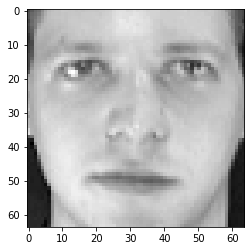

/content/drive/MyDrive/MWDB/set3_elbp_image-0/image-110.png 1403.3490205631172


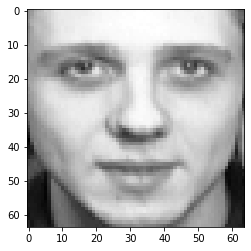

/content/drive/MyDrive/MWDB/set3_elbp_image-0/image-50.png 1434.6431389778431


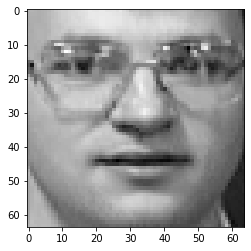

/content/drive/MyDrive/MWDB/set3_elbp_image-0/image-90.png 1442.5529427771385


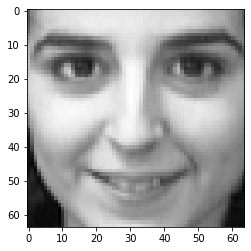

In [296]:
import matplotlib.pyplot as plt

xb = feature_dict[feature]
n = xb.shape[0]    # number of vectors    

xq = in_feature_dict[feature]
D, I = top_k_match(xb, k, xq, method=distance_dict[feature])   # actual search

# destination_dir = os.path.join(base_dir, input_dir.rstrip("/").rsplit("/",1)[1] + "_" + input_img.rstrip(".png").rstrip("/").rsplit("/",1)[1]  + "_" + feature +"_results_task3/")
destination_dir = os.path.join(base_dir, 
                               input_dir.rstrip("/").rsplit("/",1)[1] + "_" + feature +\
                               "_" + input_img.rstrip(".png").rstrip("/").rsplit("/",1)[1] if input_img!="" else input_img +\
                               "_" + feature +"_results_task3/")
if not os.path.isdir(destination_dir):
    os.makedirs(destination_dir)

image_files = get_image_file(features_dir, I)
for i in range(len(I)):
    result = Image.fromarray((images[I[i]]).astype(np.uint8))
    result.save(os.path.join(destination_dir, image_files[I[i]].split("/")[-1]))
    print(os.path.join(destination_dir, image_files[I[i]].split("/")[-1]), D[i])
    conclusion_metric.append([os.path.join(destination_dir, image_files[I[i]].split("/")[-1]), D[i]])
    plt.imshow(images[I[i]], cmap='gray')
    plt.show()

In [268]:
# UNCOMMENT to get accuracy of current dataset
"""
def get_accuracy_distances(xb,k,xq,distances):
  accuracy_dict= {d: [] for d in distances}
  for distance in distances:
    for i in range(len(xb)):
      # real_id = random.choice(range(n))
      real_id = i
      xq = np.array([xb[real_id]])

      D, I = top_k_match(xb, k, xq, method=distance)   # actual search
      accuracy_dict[distance].append(np.count_nonzero((I//10)==(real_id//10))/k)

    accuracy_dict[distance] = np.mean(accuracy_dict[distance])
  return accuracy_dict  

for feature in list(feature_dict.keys()): 
  print(feature)
  xb = feature_dict[feature]
  n = xb.shape[0]    # number of vectors    

  real_id = random.choice(range(n))
  # real_id = i
  xq = np.array([xb[real_id]])

  distances = ["euclidean", "cosine", "manhattan","earth_movers"]
  print(get_accuracy_distances(xb,k,xq,distances))
"""

# DO NOT UNCOMMENT: FOR INFORMATION ONLY
"""img
{'euclidean': 0.5399122807017543, 'cosine': 0.5043859649122807, 'manhattan': 0.5489035087719298, 'earth_movers': 0.24013157894736842}
mean
{'euclidean': 0.48508771929824557, 'cosine': 0.49583333333333324, 'manhattan': 0.4787280701754386, 'earth_movers': 0.1609649122807018}
std
{'euclidean': 0.46030701754385966, 'cosine': 0.45416666666666666, 'manhattan': 0.4923245614035088, 'earth_movers': 0.1631578947368421}
skew
{'euclidean': 0.3528508771929824, 'cosine': 0.36381578947368415, 'manhattan': 0.387280701754386, 'earth_movers': 0.13442982456140354}
elbp
{'euclidean': 0.4820175438596491, 'cosine': 0.48311403508771933, 'manhattan': 0.5078947368421053, 'earth_movers': 0.021929824561403508}
hog
{'euclidean': 0.5436403508771931, 'cosine': 0.5703947368421053, 'manhattan': 0.5517543859649122, 'earth_movers': 0.021929824561403508}
cm8x8
{'euclidean': 0.5109649122807017, 'cosine': 0.5203947368421052, 'manhattan': 0.5223684210526316, 'earth_movers': 0.021929824561403508}
all
{'euclidean': 0.5342105263157895, 'cosine': 0.5535087719298246, 'manhattan': 0.5655701754385964, 'earth_movers': 0.021929824561403508}

"""

"img\n{'euclidean': 0.5399122807017543, 'cosine': 0.5043859649122807, 'manhattan': 0.5489035087719298, 'earth_movers': 0.24013157894736842}\nmean\n{'euclidean': 0.48508771929824557, 'cosine': 0.49583333333333324, 'manhattan': 0.4787280701754386, 'earth_movers': 0.1609649122807018}\nstd\n{'euclidean': 0.46030701754385966, 'cosine': 0.45416666666666666, 'manhattan': 0.4923245614035088, 'earth_movers': 0.1631578947368421}\nskew\n{'euclidean': 0.3528508771929824, 'cosine': 0.36381578947368415, 'manhattan': 0.387280701754386, 'earth_movers': 0.13442982456140354}\nelbp\n{'euclidean': 0.4820175438596491, 'cosine': 0.48311403508771933, 'manhattan': 0.5078947368421053, 'earth_movers': 0.021929824561403508}\nhog\n{'euclidean': 0.5436403508771931, 'cosine': 0.5703947368421053, 'manhattan': 0.5517543859649122, 'earth_movers': 0.021929824561403508}\ncm8x8\n{'euclidean': 0.5109649122807017, 'cosine': 0.5203947368421052, 'manhattan': 0.5223684210526316, 'earth_movers': 0.021929824561403508}\nall\n{'e

## Task 4 : Implementation of top-k similarity search on all features

/content/drive/MyDrive/MWDB/set3_image-0/image-0.png 0.0


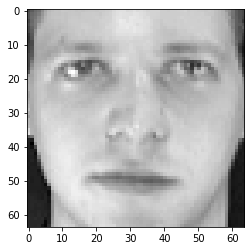

/content/drive/MyDrive/MWDB/set3_image-0/image-110.png 1724.2065


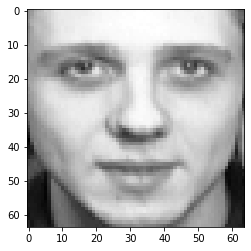

/content/drive/MyDrive/MWDB/set3_image-0/image-50.png 1790.9136


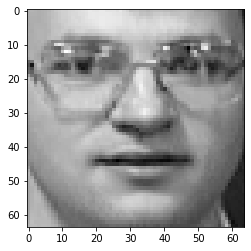

/content/drive/MyDrive/MWDB/set3_image-0/image-90.png 1823.2385


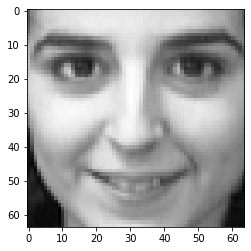

In [297]:
import matplotlib.pyplot as plt

feature="all"
xb = feature_dict[feature]
n = xb.shape[0]    # number of vectors    

xq = in_feature_dict[feature]
D, I = top_k_match(xb, k, xq, method=distance_dict[feature])   # actual search

# destination_dir = os.path.join(base_dir, input_dir.rstrip("/").rsplit("/",1)[1] + "_" + input_img.rstrip(".png").rstrip("/").rsplit("/",1)[1]  + "_" + feature +"_results_task3/")
destination_dir = os.path.join(base_dir, 
                               input_dir.rstrip("/").rsplit("/",1)[1] +\
                               "_" + input_img.rstrip(".png").rstrip("/").rsplit("/",1)[1] if input_img!="" else input_img +\
                               "_" + feature +"_results_task3/")
if not os.path.isdir(destination_dir):
  os.makedirs(destination_dir)

image_files = get_image_file(features_dir, I)
for i in range(len(I)):
  result = Image.fromarray((images[I[i]]).astype(np.uint8))
  result.save(os.path.join(destination_dir, image_files[I[i]].split("/")[-1]))
  print(os.path.join(destination_dir, image_files[I[i]].split("/")[-1]), D[i])
  conclusion_metric.append([os.path.join(destination_dir, image_files[I[i]].split("/")[-1]), D[i]])
  plt.imshow(images[I[i]], cmap='gray')
  plt.show()

In [270]:
all_features = ["cm8x8","elbp","hog"]
Dist=[]
Inx=[]
for i in range(len(all_features)):
  xb = feature_dict[all_features[i]]
  n = xb.shape[0]    # number of vectors    
  print(xb.shape)
  xq = in_feature_dict[all_features[i]]
  Di, Ii = top_k_match(xb, n-1, xq, method=distance_dict[all_features[i]])   # actual search
  Dist.append(Di)
  # destination_dir = os.path.join(base_dir, input_dir.rstrip("/").rsplit("/",1)[1] + "_" + input_img.rstrip(".png").rstrip("/").rsplit("/",1)[1]  + "_" + all_features[i] +"_results_task3/")
  destination_dir = os.path.join(base_dir, 
                                input_dir.rstrip("/").rsplit("/",1)[1] +\
                                "_" + input_img.rstrip(".png").rstrip("/").rsplit("/",1)[1] if input_img!="" else input_img +\
                                "_" + all_features[i] +"_results_task3/")

for i in range(len(all_features)):
  print("Contribution of " + all_features[i])
  print(Dist[i].sum()/np.array(Dist).sum())

(10, 192)
(10, 4096)
(10, 1764)
Contribution of cm8x8
0.007694438810650865
Contribution of elbp
0.9921697763113231
Contribution of hog
0.00013578487802589975
